<a href="https://colab.research.google.com/github/swilsonmfc/imbalanced/blob/main/WineQuality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wine Quality

# Install

In [1]:
!pip install imblearn

# Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy

from tensorflow.keras.metrics import Recall
from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.metrics import TruePositives, FalsePositives
from tensorflow.keras.metrics import TrueNegatives, FalseNegatives
from tensorflow.keras.metrics import AUC

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from imblearn.keras import BalancedBatchGenerator
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from s

# Data

In [3]:
!wget -O wine-red.csv https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
!wget -O wine-white.csv https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv

--2020-10-22 21:02:49--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84199 (82K) [application/x-httpd-php]
Saving to: ‘wine-red.csv’

wine-red.csv        100%[===================>]  82.23K   309KB/s    in 0.3s    

2020-10-22 21:02:49 (309 KB/s) - ‘wine-red.csv’ saved [84199/84199]

--2020-10-22 21:02:50--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 264426 (258K) [application/x-httpd-php]
Saving to: ‘wine-white.csv’

wine-white.csv      100%[===================>] 258.2

In [4]:
red_df   = pd.read_csv('wine-red.csv', sep=';')
red_df['type'] = 'red'
white_df = pd.read_csv('wine-white.csv', sep=';')
white_df['type'] = 'white'

df = pd.concat([red_df, white_df])
df['target'] = np.where(df.quality <= 4, 1, 0) 
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type,target
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,red,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,red,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,red,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,white,0
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,white,0
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,white,0
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white,0


# EDA

In [5]:
def plot_feature(df, feature, outcome='target'):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
  df.hist(feature, ax=ax1)
  ax1.set_xlabel(feature)
  ax1.set_title(f'Histogram for {feature}')
  df.boxplot(feature, by=outcome, ax=ax2)
  ax2.set_ylabel(feature)
  ax2.set_title(f'{feature} grouped by Target')
  plt.show();

def plot_class_density(df, feature, outcome='target'):
  fig = plt.figure(figsize=(12, 6))
  sns.kdeplot(df[feature], hue=df[outcome], palette='gist_rainbow')
  plt.show();

## Target Class
* Imbalanced 25 to 1
* A target of 1 means it is a low quality wine

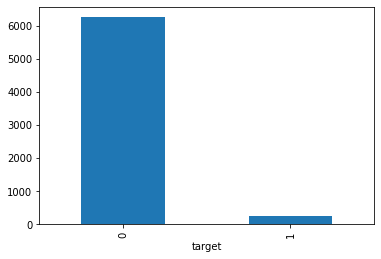

In [6]:
df.groupby('target').size().plot.bar()

In [7]:
grp = df.groupby('target').size()
(grp / min(grp))

target
0    25.410569
1     1.000000
dtype: float64

## Missing
* Nothing missing to impute

In [8]:
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
type                    0
target                  0
dtype: int64

## Wine Type
* More whites than reds

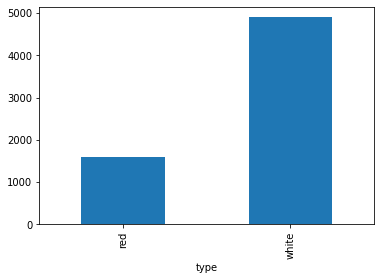

In [9]:
df.groupby('type').size().plot.bar()

## Acidity
* More "outliers" for fixed acidity in normal / high quality wines
* More variation for volatile acidity in low quality wines

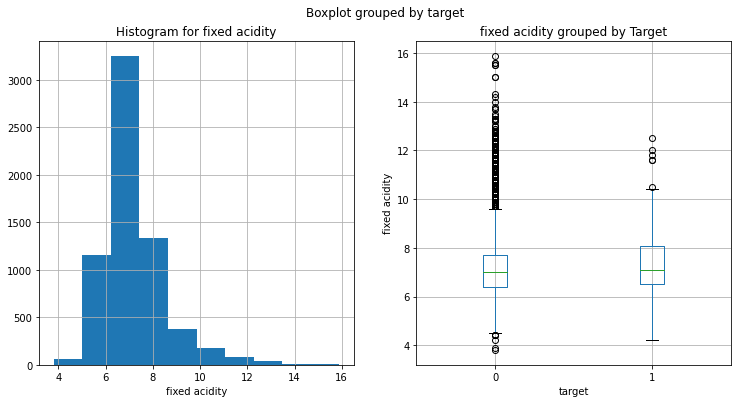

In [10]:
plot_feature(df, 'fixed acidity')

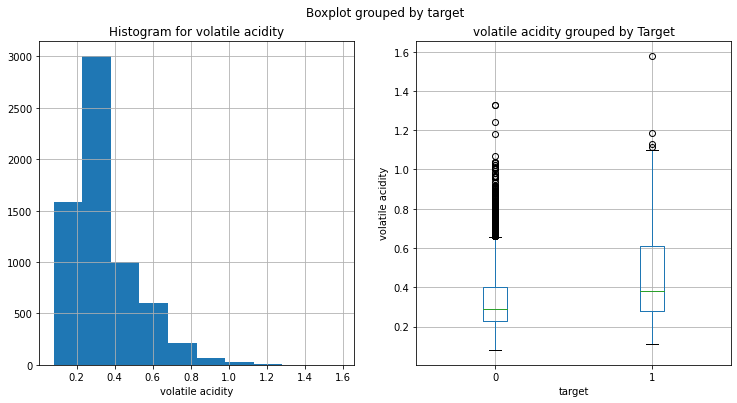

In [11]:
plot_feature(df, 'volatile acidity')

## Citric Acid

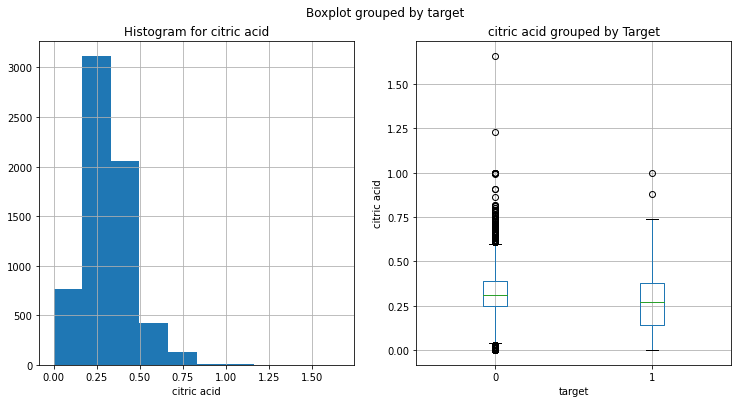

In [12]:
plot_feature(df, 'citric acid')

## Residual Sugar

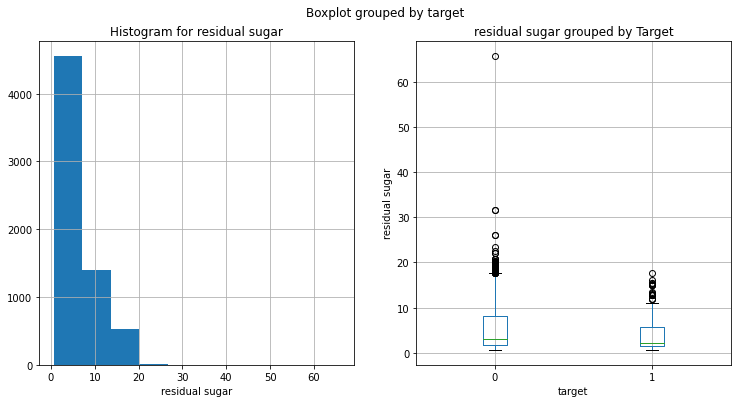

In [13]:
plot_feature(df, 'residual sugar')

## Chlorides

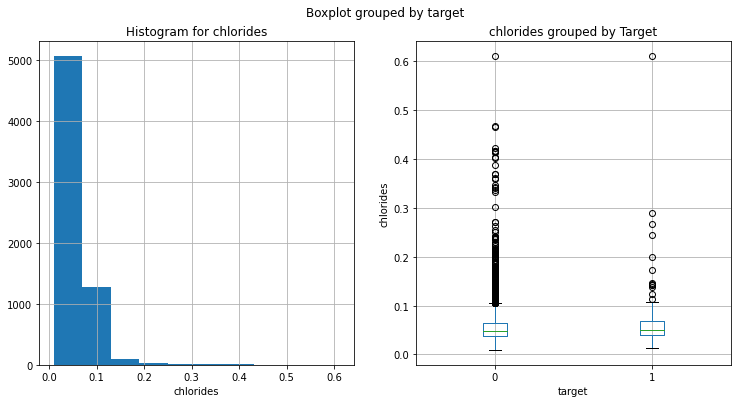

In [14]:
plot_feature(df, 'chlorides')

## Sulphur

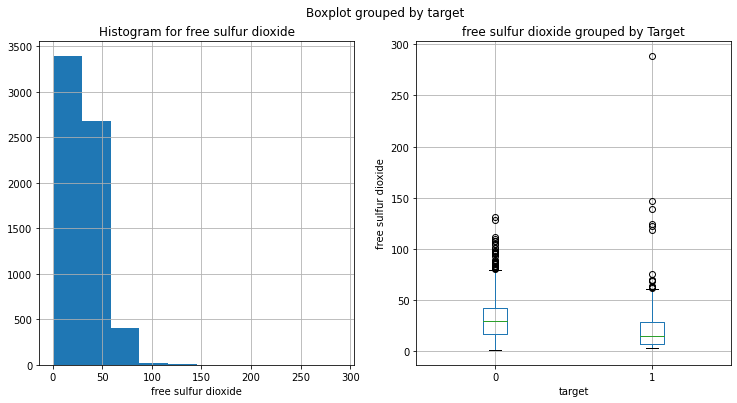

In [15]:
plot_feature(df, 'free sulfur dioxide')

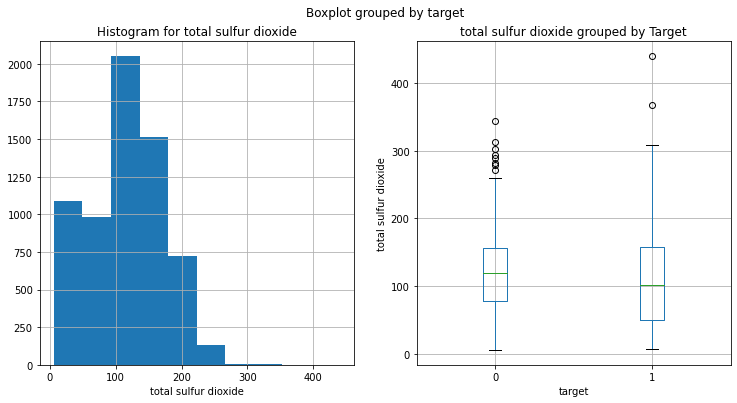

In [16]:
plot_feature(df, 'total sulfur dioxide')

## Density

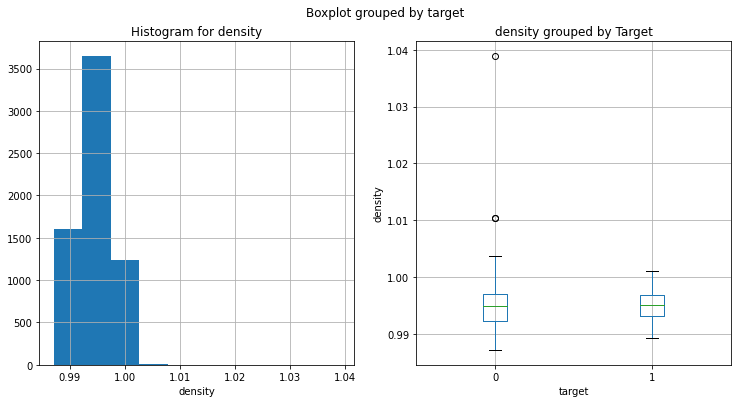

In [17]:
plot_feature(df, 'density')

## pH

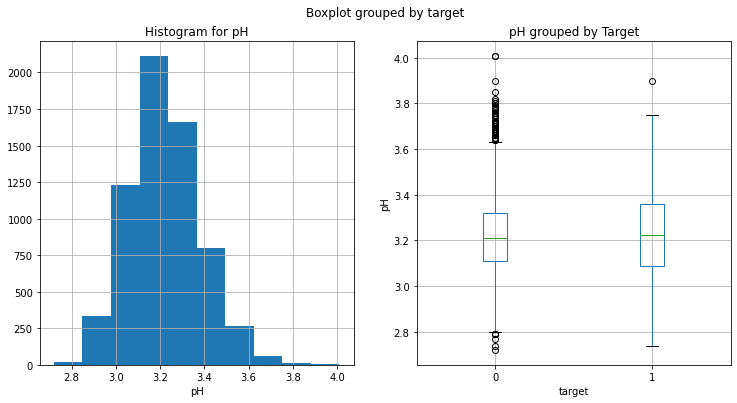

In [18]:
plot_feature(df, 'pH')

## Sulphates

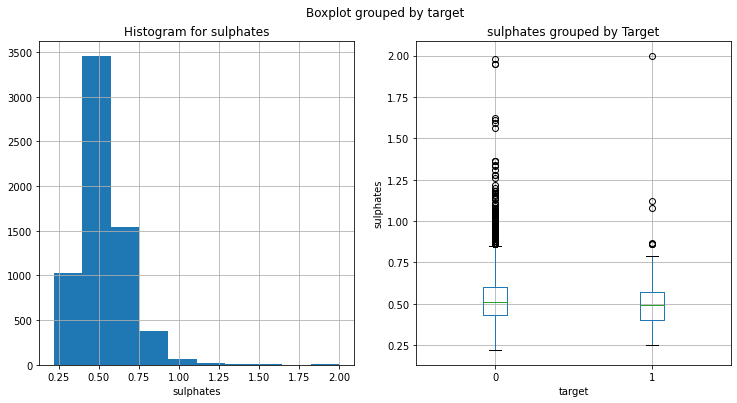

In [19]:
plot_feature(df, 'sulphates')

## Alcohol

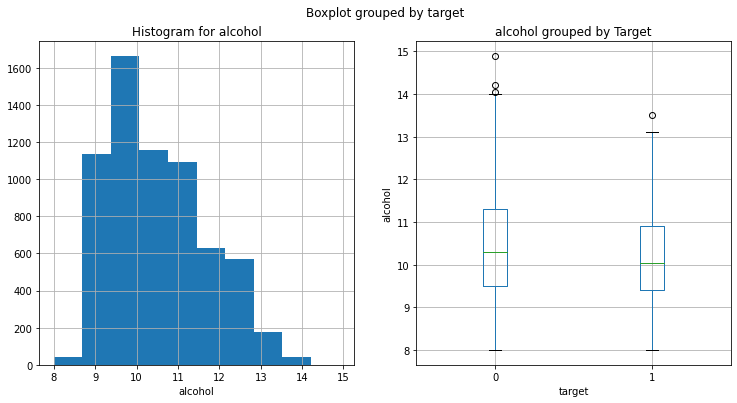

In [20]:
plot_feature(df, 'alcohol')

## Correlations

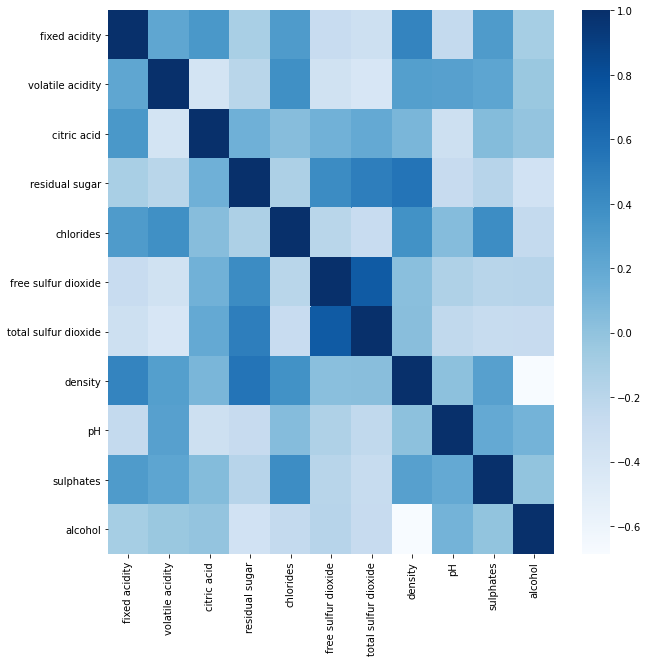

In [21]:
columns = ['fixed acidity',
           'volatile acidity',
           'citric acid',
           'residual sugar',
           'chlorides',
           'free sulfur dioxide',
           'total sulfur dioxide', 
           'density', 
           'pH',	
           'sulphates',
           'alcohol']
plt.figure(figsize=(10, 10))
sns.heatmap(df[columns].corr(), cmap='Blues');

# Training Data

In [22]:
X = df.copy()
X = X.drop(columns=['quality', 'type',	'target'])
y = df['target']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train)

## Scale
* Apply standard scaler - no need to apply clipping

In [24]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)
X_val   = scaler.transform(X_val)

In [25]:
pd.DataFrame([i for i in zip(X.columns, X_train.min(axis=1), X_train.max(axis=1))],
             columns=['Feature', 'Min', 'Max'])

,Feature,Min,Max
0,fixed acidity,-1.009096,11.475774
1,volatile acidity,-1.412366,0.569523
2,citric acid,-0.699912,0.521125
3,residual sugar,-0.785985,0.833370
4,chlorides,-1.122240,1.976673
5,free sulfur dioxide,-0.496570,1.126372
6,total sulfur dioxide,-2.019585,1.732717
7,density,-1.281801,0.895819
8,pH,-1.011785,0.323296
9,sulphates,-0.926011,3.420439


In [26]:
pd.DataFrame([i for i in zip(X.columns, X_test.min(axis=1), X_test.max(axis=1))],
             columns=['Feature', 'Min', 'Max'])

,Feature,Min,Max
0,fixed acidity,-2.011940,1.519758
1,volatile acidity,-1.477239,0.945923
2,citric acid,-0.926011,1.573287
3,residual sugar,-1.389932,2.392202
4,chlorides,-1.621932,2.093401
5,free sulfur dioxide,-1.097572,0.403353
6,total sulfur dioxide,-1.159890,1.151517
7,density,-0.676755,1.108526
8,pH,-1.339298,1.981973
9,sulphates,-1.675470,2.768441


# Metrics

In [27]:
METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc')
]

In [28]:
def score_model(y, y_hat):
  cm = confusion_matrix(y, y_hat)
  maj_precision = cm[0][0] / (cm[0][0] + cm[1][0])
  maj_recall    = cm[0][0] / (cm[0][0] + cm[0][1])
  min_precision = cm[1][1] / (cm[1][1] + cm[0][1])
  min_recall    = cm[1][1] / (cm[1][1] + cm[1][0])
  acc = accuracy_score(y, y_hat)
  f1  = f1_score(y, y_hat)
  return cm, acc, (maj_precision, maj_recall), (min_precision, min_recall), f1

# Tracking

In [29]:
cols = pd.MultiIndex.from_tuples(zip(['Majority', 'Majority', 'Minority', 'Minority', 'Scoring', 'Scoring'],
                                     ['Precision', 'Recall', 'Precision', 'Recall', 'Accuracy', 'F1']))

results_df = pd.DataFrame(columns=cols)

# Model

In [30]:
def construct_model(layers=[64], loss=BinaryCrossentropy(), dropout=0.2):
  model = Sequential()
  model.add(Dense(layers[0], activation='relu', input_shape=(X_train.shape[-1],)))
  
  for layer in layers[1:]:
    model.add(Dense(layer, activation='relu'))
  
  model.add(Dropout(dropout))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=loss,
      metrics=METRICS)

  return model

In [31]:
def plot_history(history):
  plt.figure(figsize=(10,8))
  
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    
    plt.plot(history.epoch, 
             history.history[metric], 
             color='blue', 
             label='Train')
    plt.plot(history.epoch, 
             history.history['val_' + metric],
             color='blue', 
             linestyle="--", 
             label='Val')
    
    plt.xlabel('Epoch')
    plt.ylabel(name)
    
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.2,1])
    else:
      plt.ylim([0,1])
    plt.legend()

# Baseline

In [32]:
y_hat_proba = np.repeat(0, len(X_test))
y_hat = np.where(y_hat_proba > 0.5, 1, 0)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1567
           1       0.00      0.00      0.00        58

    accuracy                           0.96      1625
   macro avg       0.48      0.50      0.49      1625
weighted avg       0.93      0.96      0.95      1625



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
cm, acc, maj, min, f1 = score_model(y_test, y_hat)
results_df.loc['Baseline'] = [*maj, *min, acc, f1]
results_df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """


Majority         Minority          Scoring     
         Precision Recall Precision Recall  Accuracy   F1
Baseline  0.964308    1.0       NaN    0.0  0.964308  0.0

# Random
* Simplest baseline, use random weights and 

In [34]:
EPOCHS = 100
BATCH_SIZE = 256

early_stopping = EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)

In [35]:
model = construct_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                768       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.predict(X_train[:10])

array([[0.17000678],
       [0.42358476],
       [0.40529197],
       [0.51355994],
       [0.39178836],
       [0.6075268 ],
       [0.4215722 ],
       [0.34154308],
       [0.44838017],
       [0.29398865]], dtype=float32)

In [37]:
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.7211


In [38]:
y_hat_proba = model.predict(X_test)
y_hat = np.where(y_hat_proba > 0.5, 1, 0)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.95      0.53      0.68      1567
           1       0.02      0.22      0.03        58

    accuracy                           0.52      1625
   macro avg       0.48      0.38      0.36      1625
weighted avg       0.92      0.52      0.66      1625



In [39]:
cm, acc, maj, min, f1 = score_model(y_test, y_hat)
results_df.loc['Random'] = [*maj, *min, acc, f1]
results_df

Majority            Minority             Scoring          
         Precision    Recall Precision    Recall  Accuracy        F1
Baseline  0.964308  1.000000       NaN  0.000000  0.964308  0.000000
Random    0.948980  0.534142  0.017497  0.224138  0.523077  0.032459

# Unbalanced

In [40]:
model = construct_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                768       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________


In [41]:
history_unbalanced = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(X_val, y_val))

Epoch 1/100
15/15 [==============================] - 1s 50ms/step - loss: 0.6533 - tp: 81.0000 - fp: 2843.0000 - tn: 4189.0000 - fn: 195.0000 - accuracy: 0.5843 - precision: 0.0277 - recall: 0.2935 - auc: 0.4036 - val_loss: 0.5466 - val_tp: 2.0000 - val_fp: 62.0000 - val_tn: 1106.0000 - val_fn: 48.0000 - val_accuracy: 0.9097 - val_precision: 0.0312 - val_recall: 0.0400 - val_auc: 0.4097
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 0.4903 - tp: 4.0000 - fp: 221.0000 - tn: 3295.0000 - fn: 134.0000 - accuracy: 0.9028 - precision: 0.0178 - recall: 0.0290 - auc: 0.4816 - val_loss: 0.4260 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1168.0000 - val_fn: 50.0000 - val_accuracy: 0.9589 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4373
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 0.3842 - tp: 0.0000e+00 - fp: 15.0000 - tn: 3501.0000 - fn: 138.0000 - accuracy: 0.9581 - precision: 0.0000e+00 - recall: 0.0000e+00 - 

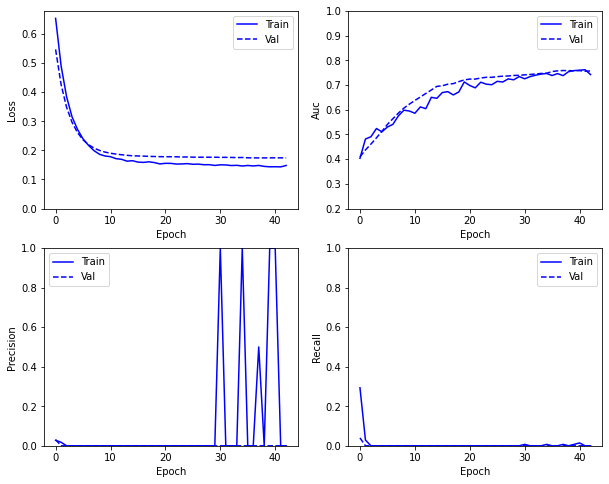

In [42]:
plot_history(history_unbalanced)

In [43]:
y_hat_proba = model.predict(X_test)
y_hat = np.where(y_hat_proba > 0.5, 1, 0)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1567
           1       0.00      0.00      0.00        58

    accuracy                           0.96      1625
   macro avg       0.48      0.50      0.49      1625
weighted avg       0.93      0.96      0.95      1625



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
cm, acc, maj, min, f1 = score_model(y_test, y_hat)
results_df.loc['Unbalanced'] = [*maj, *min, acc, f1]
results_df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """


Majority            Minority             Scoring          
           Precision    Recall Precision    Recall  Accuracy        F1
Baseline    0.964308  1.000000       NaN  0.000000  0.964308  0.000000
Random      0.948980  0.534142  0.017497  0.224138  0.523077  0.032459
Unbalanced  0.964308  1.000000       NaN  0.000000  0.964308  0.000000

# Weighted Model

In [45]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
pos = y_train.sum()
neg = len(y_train) - pos
tot = len(y_train)

weight_neg = (1 / neg) * (tot) / 2.0 
weight_pos = (1 / pos) * (tot) / 2.0

class_weight = {0: weight_neg, 1: weight_pos}

print('Weight Negative: {:.2f}'.format(weight_neg))
print('Weight Positive: {:.2f}'.format(weight_pos))

Weight Negative: 0.52
Weight Positive: 13.24


In [46]:
model = construct_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                768       
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________


In [47]:
history_weighted = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    class_weight=class_weight,
    validation_data=(X_val, y_val))

Epoch 1/100
15/15 [==============================] - 1s 51ms/step - loss: 0.7474 - tp: 57.0000 - fp: 1456.0000 - tn: 3228.0000 - fn: 131.0000 - accuracy: 0.6743 - precision: 0.0377 - recall: 0.3032 - auc: 0.4924 - val_loss: 0.6934 - val_tp: 21.0000 - val_fp: 477.0000 - val_tn: 691.0000 - val_fn: 29.0000 - val_accuracy: 0.5846 - val_precision: 0.0422 - val_recall: 0.4200 - val_auc: 0.5032
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7018 - tp: 73.0000 - fp: 1533.0000 - tn: 1983.0000 - fn: 65.0000 - accuracy: 0.5627 - precision: 0.0455 - recall: 0.5290 - auc: 0.5561 - val_loss: 0.6941 - val_tp: 31.0000 - val_fp: 487.0000 - val_tn: 681.0000 - val_fn: 19.0000 - val_accuracy: 0.5846 - val_precision: 0.0598 - val_recall: 0.6200 - val_auc: 0.6261
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 0.6592 - tp: 83.0000 - fp: 1435.0000 - tn: 2081.0000 - fn: 55.0000 - accuracy: 0.5922 - precision: 0.0547 - recall: 0.6014 - auc: 0.6558 - val_loss

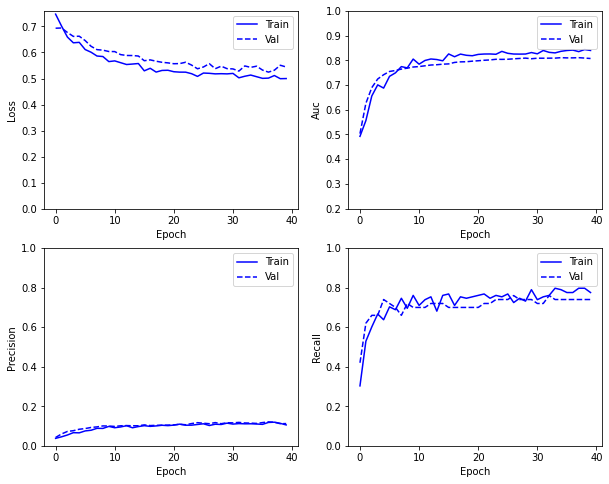

In [48]:
plot_history(history_weighted)

In [49]:
y_hat_proba = model.predict(X_test)
y_hat = np.where(y_hat_proba > 0.5, 1, 0)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.99      0.77      0.86      1567
           1       0.11      0.74      0.18        58

    accuracy                           0.77      1625
   macro avg       0.55      0.75      0.52      1625
weighted avg       0.96      0.77      0.84      1625



In [50]:
cm, acc, maj, min, f1 = score_model(y_test, y_hat)
results_df.loc['Weighted'] = [*maj, *min, acc, f1]
results_df

Majority            Minority             Scoring          
           Precision    Recall Precision    Recall  Accuracy        F1
Baseline    0.964308  1.000000       NaN  0.000000  0.964308  0.000000
Random      0.948980  0.534142  0.017497  0.224138  0.523077  0.032459
Unbalanced  0.964308  1.000000       NaN  0.000000  0.964308  0.000000
Weighted    0.987685  0.767709  0.105651  0.741379  0.766769  0.184946

# Over Sample

In [51]:
model = construct_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                768       
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________


In [52]:
sampler = RandomOverSampler()
X_over, y_over = sampler.fit_resample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [53]:
history_over_sample = model.fit(
    X_over,
    y_over,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(X_val, y_val))

Epoch 1/100
28/28 [==============================] - 1s 28ms/step - loss: 0.6624 - tp: 2676.0000 - fp: 2222.0000 - tn: 2462.0000 - fn: 890.0000 - accuracy: 0.6228 - precision: 0.5463 - recall: 0.7504 - auc: 0.6940 - val_loss: 0.6766 - val_tp: 40.0000 - val_fp: 481.0000 - val_tn: 687.0000 - val_fn: 10.0000 - val_accuracy: 0.5969 - val_precision: 0.0768 - val_recall: 0.8000 - val_auc: 0.7721
Epoch 2/100
28/28 [==============================] - 0s 3ms/step - loss: 0.6112 - tp: 2581.0000 - fp: 1284.0000 - tn: 2232.0000 - fn: 935.0000 - accuracy: 0.6844 - precision: 0.6678 - recall: 0.7341 - auc: 0.7505 - val_loss: 0.6355 - val_tp: 35.0000 - val_fp: 386.0000 - val_tn: 782.0000 - val_fn: 15.0000 - val_accuracy: 0.6708 - val_precision: 0.0831 - val_recall: 0.7000 - val_auc: 0.7583
Epoch 3/100
28/28 [==============================] - 0s 3ms/step - loss: 0.5770 - tp: 2644.0000 - fp: 1106.0000 - tn: 2410.0000 - fn: 872.0000 - accuracy: 0.7187 - precision: 0.7051 - recall: 0.7520 - auc: 0.7871 - 

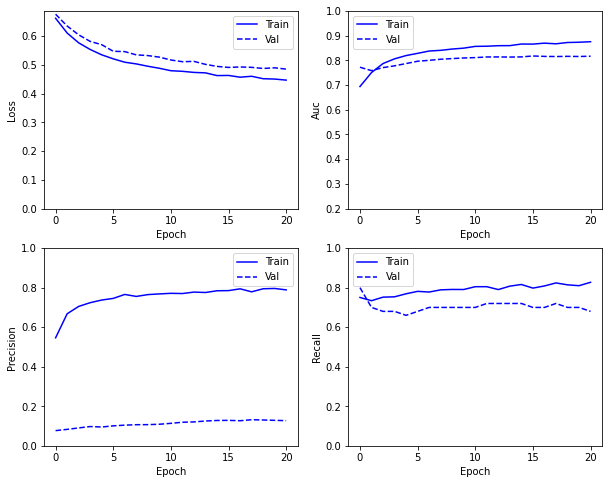

In [54]:
plot_history(history_over_sample)

In [55]:
y_hat_proba = model.predict(X_test)
y_hat = np.where(y_hat_proba > 0.5, 1, 0)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.99      0.80      0.88      1567
           1       0.11      0.67      0.19        58

    accuracy                           0.79      1625
   macro avg       0.55      0.73      0.53      1625
weighted avg       0.95      0.79      0.86      1625



In [56]:
cm, acc, maj, min, f1 = score_model(y_test, y_hat)
results_df.loc['Over Sample'] = [*maj, *min, acc, f1]
results_df

Majority            Minority             Scoring          
            Precision    Recall Precision    Recall  Accuracy        F1
Baseline     0.964308  1.000000       NaN  0.000000  0.964308  0.000000
Random       0.948980  0.534142  0.017497  0.224138  0.523077  0.032459
Unbalanced   0.964308  1.000000       NaN  0.000000  0.964308  0.000000
Weighted     0.987685  0.767709  0.105651  0.741379  0.766769  0.184946
Over Sample  0.985004  0.796426  0.108939  0.672414  0.792000  0.187500

# Under Sample

In [57]:
model = construct_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 64)                768       
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________


In [58]:
sampler = RandomUnderSampler()
X_under, y_under = sampler.fit_resample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [59]:
history_under_sample = model.fit(
    X_under,
    y_under,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(X_val, y_val))

Epoch 1/100
2/2 [==============================] - 1s 370ms/step - loss: 0.6943 - tp: 116.0000 - fp: 301.0000 - tn: 1005.0000 - fn: 72.0000 - accuracy: 0.7503 - precision: 0.2782 - recall: 0.6170 - auc: 0.7810 - val_loss: 0.7291 - val_tp: 33.0000 - val_fp: 603.0000 - val_tn: 565.0000 - val_fn: 17.0000 - val_accuracy: 0.4910 - val_precision: 0.0519 - val_recall: 0.6600 - val_auc: 0.5615
Epoch 2/100
2/2 [==============================] - 0s 14ms/step - loss: 0.7183 - tp: 77.0000 - fp: 79.0000 - tn: 59.0000 - fn: 61.0000 - accuracy: 0.4928 - precision: 0.4936 - recall: 0.5580 - auc: 0.4953 - val_loss: 0.7291 - val_tp: 33.0000 - val_fp: 596.0000 - val_tn: 572.0000 - val_fn: 17.0000 - val_accuracy: 0.4967 - val_precision: 0.0525 - val_recall: 0.6600 - val_auc: 0.5842
Epoch 3/100
2/2 [==============================] - 0s 13ms/step - loss: 0.6883 - tp: 87.0000 - fp: 70.0000 - tn: 68.0000 - fn: 51.0000 - accuracy: 0.5616 - precision: 0.5541 - recall: 0.6304 - auc: 0.5892 - val_loss: 0.7299 - v

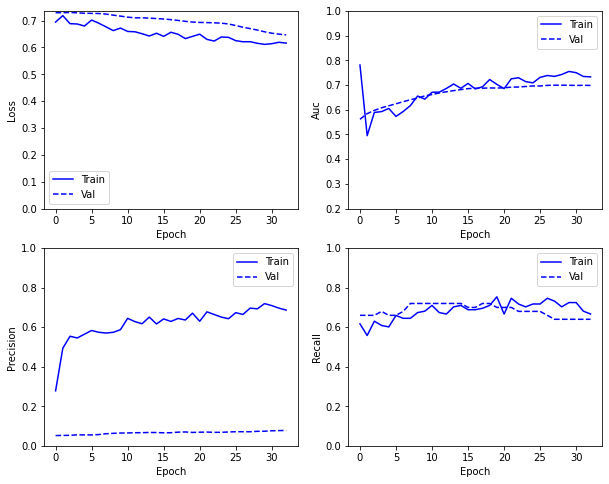

In [60]:
plot_history(history_under_sample)

In [61]:
y_hat_proba = model.predict(X_test)
y_hat = np.where(y_hat_proba > 0.5, 1, 0)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.98      0.64      0.78      1567
           1       0.06      0.64      0.11        58

    accuracy                           0.64      1625
   macro avg       0.52      0.64      0.45      1625
weighted avg       0.95      0.64      0.75      1625



In [62]:
cm, acc, maj, min, f1 = score_model(y_test, y_hat)
results_df.loc['Under Sample'] = [*maj, *min, acc, f1]
results_df

Majority            Minority             Scoring          
             Precision    Recall Precision    Recall  Accuracy        F1
Baseline      0.964308  1.000000       NaN  0.000000  0.964308  0.000000
Random        0.948980  0.534142  0.017497  0.224138  0.523077  0.032459
Unbalanced    0.964308  1.000000       NaN  0.000000  0.964308  0.000000
Weighted      0.987685  0.767709  0.105651  0.741379  0.766769  0.184946
Over Sample   0.985004  0.796426  0.108939  0.672414  0.792000  0.187500
Under Sample  0.979631  0.644544  0.062290  0.637931  0.644308  0.113497

# Batch Balancing

In [63]:
model = construct_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 64)                768       
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________


In [64]:
training_generator = BalancedBatchGenerator(
    X_train, 
    y_train.to_numpy(), 
    sampler=RandomOverSampler(), 
    batch_size=32, 
    random_state=42)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [65]:
history_batch_balanced = model.fit(
    training_generator,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    callbacks = [early_stopping])

Epoch 1/100


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


219/219 [==============================] - 1s 5ms/step - loss: 0.6103 - tp: 2429.0000 - fp: 1636.0000 - tn: 3036.0000 - fn: 1125.0000 - accuracy: 0.6644 - precision: 0.5975 - recall: 0.6835 - auc: 0.7316 - val_loss: 0.5660 - val_tp: 34.0000 - val_fp: 307.0000 - val_tn: 861.0000 - val_fn: 16.0000 - val_accuracy: 0.7348 - val_precision: 0.0997 - val_recall: 0.6800 - val_auc: 0.7835
Epoch 2/100
219/219 [==============================] - 0s 2ms/step - loss: 0.5261 - tp: 2680.0000 - fp: 914.0000 - tn: 2590.0000 - fn: 824.0000 - accuracy: 0.7520 - precision: 0.7457 - recall: 0.7648 - auc: 0.8239 - val_loss: 0.5389 - val_tp: 34.0000 - val_fp: 281.0000 - val_tn: 887.0000 - val_fn: 16.0000 - val_accuracy: 0.7562 - val_precision: 0.1079 - val_recall: 0.6800 - val_auc: 0.7986
Epoch 3/100
219/219 [==============================] - 0s 2ms/step - loss: 0.4958 - tp: 2752.0000 - fp: 842.0000 - tn: 2662.0000 - fn: 752.0000 - accuracy: 0.7725 - precision: 0.7657 - recall: 0.7854 - auc: 0.8444 - val_loss

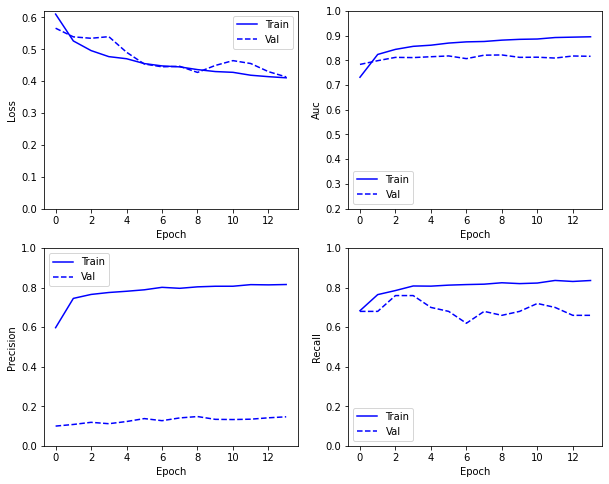

In [66]:
plot_history(history_batch_balanced)

In [67]:
y_hat_proba = model.predict(X_test)
y_hat = np.where(y_hat_proba > 0.5, 1, 0)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.98      0.84      0.91      1567
           1       0.13      0.64      0.21        58

    accuracy                           0.83      1625
   macro avg       0.56      0.74      0.56      1625
weighted avg       0.95      0.83      0.88      1625



In [68]:
cm, acc, maj, min, f1 = score_model(y_test, y_hat)
results_df.loc['Balanced Batching'] = [*maj, *min, acc, f1]
results_df

Majority            Minority             Scoring          
                  Precision    Recall Precision    Recall  Accuracy        F1
Baseline           0.964308  1.000000       NaN  0.000000  0.964308  0.000000
Random             0.948980  0.534142  0.017497  0.224138  0.523077  0.032459
Unbalanced         0.964308  1.000000       NaN  0.000000  0.964308  0.000000
Weighted           0.987685  0.767709  0.105651  0.741379  0.766769  0.184946
Over Sample        0.985004  0.796426  0.108939  0.672414  0.792000  0.187500
Under Sample       0.979631  0.644544  0.062290  0.637931  0.644308  0.113497
Balanced Batching  0.984270  0.838545  0.127586  0.637931  0.831385  0.212644

# Focal Loss

In [69]:
def focal_loss(y_true, y_pred):
    gamma = 2.0
    alpha = 0.25 
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

In [70]:
model = construct_model(loss=focal_loss)
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                768       
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________


In [71]:
history_focal = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(X_val, y_val))

Epoch 1/100
15/15 [==============================] - 1s 51ms/step - loss: 31.8178 - tp: 78.0000 - fp: 1284.0000 - tn: 3400.0000 - fn: 110.0000 - accuracy: 0.7139 - precision: 0.0573 - recall: 0.4149 - auc: 0.6179 - val_loss: 18.8566 - val_tp: 7.0000 - val_fp: 172.0000 - val_tn: 996.0000 - val_fn: 43.0000 - val_accuracy: 0.8235 - val_precision: 0.0391 - val_recall: 0.1400 - val_auc: 0.5216
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 16.0274 - tp: 9.0000 - fp: 323.0000 - tn: 3193.0000 - fn: 129.0000 - accuracy: 0.8763 - precision: 0.0271 - recall: 0.0652 - auc: 0.4745 - val_loss: 10.2230 - val_tp: 0.0000e+00 - val_fp: 4.0000 - val_tn: 1164.0000 - val_fn: 50.0000 - val_accuracy: 0.9557 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5022
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 9.3989 - tp: 3.0000 - fp: 28.0000 - tn: 3488.0000 - fn: 135.0000 - accuracy: 0.9554 - precision: 0.0968 - recall: 0.0217 - auc: 0.4777 

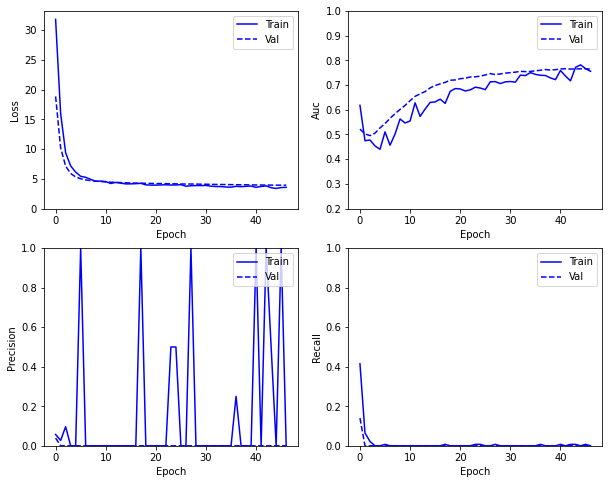

In [72]:
plot_history(history_focal)

In [73]:
y_hat_proba = model.predict(X_test)
y_hat = np.where(y_hat_proba > 0.5, 1, 0)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1567
           1       0.00      0.00      0.00        58

    accuracy                           0.96      1625
   macro avg       0.48      0.50      0.49      1625
weighted avg       0.93      0.96      0.95      1625



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [74]:
cm, acc, maj, min, f1 = score_model(y_test, y_hat)
results_df.loc['Focal Loss'] = [*maj, *min, acc, f1]
results_df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """


Majority            Minority             Scoring          
                  Precision    Recall Precision    Recall  Accuracy        F1
Baseline           0.964308  1.000000       NaN  0.000000  0.964308  0.000000
Random             0.948980  0.534142  0.017497  0.224138  0.523077  0.032459
Unbalanced         0.964308  1.000000       NaN  0.000000  0.964308  0.000000
Weighted           0.987685  0.767709  0.105651  0.741379  0.766769  0.184946
Over Sample        0.985004  0.796426  0.108939  0.672414  0.792000  0.187500
Under Sample       0.979631  0.644544  0.062290  0.637931  0.644308  0.113497
Balanced Batching  0.984270  0.838545  0.127586  0.637931  0.831385  0.212644
Focal Loss         0.964308  1.000000       NaN  0.000000  0.964308  0.000000

# Focal Loss + Over Sample

In [75]:
model = construct_model(loss=focal_loss)
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 64)                768       
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________


In [76]:
sampler = RandomOverSampler()
X_over, y_over = sampler.fit_resample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [77]:
history_focal_over_sample = model.fit(
    X_over,
    y_over,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(X_val, y_val))

Epoch 1/100
28/28 [==============================] - 1s 30ms/step - loss: 33.2692 - tp: 2812.0000 - fp: 2480.0000 - tn: 2204.0000 - fn: 754.0000 - accuracy: 0.6080 - precision: 0.5314 - recall: 0.7886 - auc: 0.6932 - val_loss: 27.6401 - val_tp: 25.0000 - val_fp: 337.0000 - val_tn: 831.0000 - val_fn: 25.0000 - val_accuracy: 0.7028 - val_precision: 0.0691 - val_recall: 0.5000 - val_auc: 0.5996
Epoch 2/100
28/28 [==============================] - 0s 3ms/step - loss: 20.2736 - tp: 1300.0000 - fp: 706.0000 - tn: 2810.0000 - fn: 2216.0000 - accuracy: 0.5845 - precision: 0.6481 - recall: 0.3697 - auc: 0.6025 - val_loss: 17.5475 - val_tp: 13.0000 - val_fp: 94.0000 - val_tn: 1074.0000 - val_fn: 37.0000 - val_accuracy: 0.8924 - val_precision: 0.1215 - val_recall: 0.2600 - val_auc: 0.6939
Epoch 3/100
28/28 [==============================] - 0s 3ms/step - loss: 18.3503 - tp: 1169.0000 - fp: 428.0000 - tn: 3088.0000 - fn: 2347.0000 - accuracy: 0.6054 - precision: 0.7320 - recall: 0.3325 - auc: 0.66

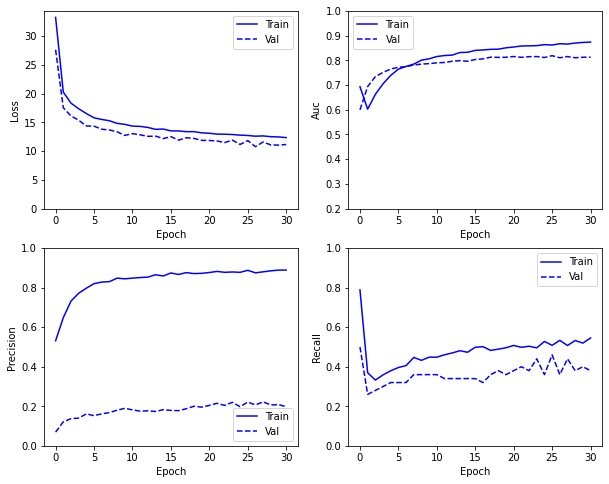

In [78]:
plot_history(history_focal_over_sample)

In [79]:
y_hat_proba = model.predict(X_test)
y_hat = np.where(y_hat_proba > 0.5, 1, 0)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.98      0.93      0.96      1567
           1       0.20      0.45      0.28        58

    accuracy                           0.92      1625
   macro avg       0.59      0.69      0.62      1625
weighted avg       0.95      0.92      0.93      1625



In [80]:
cm, acc, maj, min, f1 = score_model(y_test, y_hat)
results_df.loc['Focal Loss + Over Sample'] = [*maj, *min, acc, f1]
results_df

Majority            ...   Scoring          
                         Precision    Recall  ...  Accuracy        F1
Baseline                  0.964308  1.000000  ...  0.964308  0.000000
Random                    0.948980  0.534142  ...  0.523077  0.032459
Unbalanced                0.964308  1.000000  ...  0.964308  0.000000
Weighted                  0.987685  0.767709  ...  0.766769  0.184946
Over Sample               0.985004  0.796426  ...  0.792000  0.187500
Under Sample              0.979631  0.644544  ...  0.644308  0.113497
Balanced Batching         0.984270  0.838545  ...  0.831385  0.212644
Focal Loss                0.964308  1.000000  ...  0.964308  0.000000
Focal Loss + Over Sample  0.978610  0.934269  ...  0.916923  0.278075

[9 rows x 6 columns]

# Outcome

## F1 Score
* Highest F1 Score represents a balance between precision and recall

In [81]:
results_df.sort_values(('Scoring', 'F1'), ascending=False)

Majority            ...   Scoring          
                         Precision    Recall  ...  Accuracy        F1
Focal Loss + Over Sample  0.978610  0.934269  ...  0.916923  0.278075
Balanced Batching         0.984270  0.838545  ...  0.831385  0.212644
Over Sample               0.985004  0.796426  ...  0.792000  0.187500
Weighted                  0.987685  0.767709  ...  0.766769  0.184946
Under Sample              0.979631  0.644544  ...  0.644308  0.113497
Random                    0.948980  0.534142  ...  0.523077  0.032459
Baseline                  0.964308  1.000000  ...  0.964308  0.000000
Unbalanced                0.964308  1.000000  ...  0.964308  0.000000
Focal Loss                0.964308  1.000000  ...  0.964308  0.000000

[9 rows x 6 columns]

## Minority Recall
* To get higher recall on the minority class we're sacrificing precision
* If we care more about false positives vs false negatives use a different F-beta score (i.e. F2 or F0.5)

In [82]:
results_df.sort_values(('Minority', 'Recall'), ascending=False)

Majority            ...   Scoring          
                         Precision    Recall  ...  Accuracy        F1
Weighted                  0.987685  0.767709  ...  0.766769  0.184946
Over Sample               0.985004  0.796426  ...  0.792000  0.187500
Under Sample              0.979631  0.644544  ...  0.644308  0.113497
Balanced Batching         0.984270  0.838545  ...  0.831385  0.212644
Focal Loss + Over Sample  0.978610  0.934269  ...  0.916923  0.278075
Random                    0.948980  0.534142  ...  0.523077  0.032459
Baseline                  0.964308  1.000000  ...  0.964308  0.000000
Unbalanced                0.964308  1.000000  ...  0.964308  0.000000
Focal Loss                0.964308  1.000000  ...  0.964308  0.000000

[9 rows x 6 columns]